In [13]:
import jax
from cft import *
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm
import optax
from jax import jit, vmap, lax, grad

from functools import partial

from scipy import optimize

jax.config.update("jax_enable_x64", True)

In [5]:
def boots(beta,c, params, opt_fn, opt_state, steps=100):
    """ finds deltas

        Params:
        beta - random point for beta
        c - central charge
        deltas - intitalised deltas
        opt_fn - optimization function e.g. Adam
        opt_state - initial state

        Returns:
        losses, deltas, state

    """
    @jit
    def loss_function(params):
        identy = vmap(reduced_partition_function_spinless, in_axes=(0,0,None), out_axes=0)(params, beta, c)
        transformed = vmap(reduced_partition_function_spinless, in_axes=(0,0, None), out_axes=0)(params, 1/beta, c)
        return jnp.mean((identy-transformed)**2) # mean squared loss

    losses = []
    for _ in tqdm(range(steps)):
        # loss and gradients calulated with 
        loss, grads = jax.value_and_grad(loss_function)(params) 
        updates, opt_state = opt_fn(grads, opt_state)
        params += updates
        losses.append(loss) 

    return jnp.stack(losses), params, opt_state


100%|██████████| 1000/1000 [00:03<00:00, 280.91it/s]


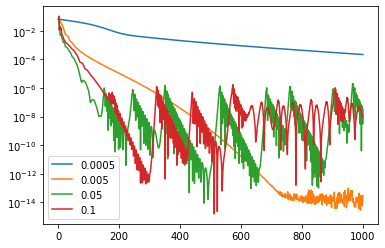

In [66]:
batch_size = 128
rng = random.PRNGKey(12)
keys = random.split(rng, 2)
beta = (random.uniform(keys[0], (batch_size,)) + 1/2 )
params = random.uniform(keys[1], (batch_size, 2, 10))*2

c = 1/2
step=1000

# test for different learning rates
for lr in [5e-4, 5e-3, 5e-2, 0.1]:
    adam = optax.adam(learning_rate=lr)
    params = random.uniform(keys[1], (batch_size, 2, 10))*2
    losses, params, _ = boots(beta, c, params, opt_fn=adam.update, opt_state=adam.init(params),steps=step)
    steps = np.linspace(1,step,step)
    plt.plot(steps,losses,label=f"{lr}")
    plt.yscale("log")
    plt.legend()

    # print(learned_deltas)

In [78]:
batch_size = 128
rng = random.PRNGKey(12)
keys = random.split(rng, 2)
beta = (random.uniform(keys[0], (batch_size,)) + 1/2 )
# params = random.uniform(keys[1], (batch_size, 2, 10))*2

step=100000
lr = 0.00005
# params = random.uniform(keys[1], (batch_size, 2, 6))*10

for epoch in range(1):
    key_n, *keys = random.split(key_n, 3)
    # beta = (random.uniform(keys[0], (batch_size,)) + 1/2 )
    c = 3.5
    adam = optax.adam(learning_rate=lr)
    # if epoch > 2:
    # lr = lr/10
    losses, params, _ = boots(beta, c, params, opt_fn=adam.update, opt_state=adam.init(params),steps=step)
    steps = np.linspace(epoch*step+1,(epoch+1)*step,step)
    plt.plot(steps,losses)
    plt.yscale("log")


  5%|▍         | 4521/100000 [00:15<05:24, 294.38it/s]


KeyboardInterrupt: 

## Random Rough stuff beyond this point

In [95]:
@jit
def loss_function(params, beta, c):
        identy = vmap(reduced_partition_function_spinless, in_axes=(0,0,None), out_axes=0)(params, beta, c)
        transformed = vmap(reduced_partition_function_spinless, in_axes=(0,0, None), out_axes=0)(params, 1/beta, c)
        return jnp.mean((identy-transformed)**2) # mean squared loss


In [104]:
from jaxopt import ScipyRootFinding

In [118]:
laguerre_deltas = vmap(laguerre_at_x, in_axes=( None, 0), out_axes=0)
c = 12
x = -(c-1)/12

# @partial(jit, static_argnums=(1))
def primal(params, l ):
    h = l//2
    deltas = lax.dynamic_slice(params, (0,),(h,))
    rhos = lax.dynamic_slice(params, (h,),(h,))
    deltas = deltas + x
    lps = laguerre_deltas(l-1, deltas)
    maxx = jnp.abs(jnp.max(lps))
    lps = lps/maxx
    lp0 = laguerre_at_0(l-1, x)
    rhos = rhos.reshape(h,1)
    rho_lps = jnp.sum(rhos * lps, axis = 0)
    return  1 + rho_lps/lp0
    
@jit   
def dual(params):
    pass

params = jnp.array([2.3, 3.4,5.13, 500, 24, 100 ])


solver = ScipyRootFinding(method='hybr', jit=False, optimality_fun=primal, use_jacrev=False)
res = solver.run(params, len(params))

In [119]:
res.params

DeviceArray([2.13170779e+00, 3.43455791e+00, 5.12886294e+00,
             5.25544843e+05, 5.01362702e+04, 4.01697933e+02],            dtype=float64)

In [120]:
primal(res.params, len(params))

DeviceArray([ 5.30335775e-11, -1.80013782e-11,  3.21498383e-11,
              6.89589497e-11,  8.68194405e-11,  8.89548435e-11],            dtype=float64)

In [98]:

laguerre_deltas = vmap(laguerre_at_x, in_axes=( None, 0), out_axes=0)
c = 12
x = -(c-1)/12

def primal(params, l):
    h = l//2
    deltas = lax.dynamic_slice(params, (0,),(h,))
    rhos = lax.dynamic_slice(params, (h,),(h,))
    deltas = deltas + x
    lps = laguerre_deltas(l-1, deltas)
    max_l = jnp.abs(jnp.max(lps))
    lps = lps/max_l
    lp0 = laguerre_at_0(l-1, x)
    rhos = rhos.reshape(h,1)
    rho_lps = jnp.sum(rhos * lps, axis = 0)
    return  1 + rho_lps/lp0

params = jnp.array([2.13, 3.4, 400, 100])

def nr(f_, x0, max_iter = 100, tol= 1e-8):
    x = x0
    i = 0
    f = partial(f_, l = len(x0))
    while jnp.linalg.norm(f(x)) > tol and i < max_iter:
        J = jax.jacfwd(f)(x)
        delta_x = jnp.linalg.solve(J, -f(x))
        x = x + delta_x
        i += 1
    return x, i

In [99]:
p,i = nr(primal, params)
p

DeviceArray([  2.23054763,   3.80388495, 538.16833339,  24.71472451], dtype=float64)

In [102]:
primal(p,4)

DeviceArray([1.11022302e-16, 1.11022302e-16, 2.22044605e-16,
             4.44089210e-16], dtype=float64)